# Quantum feature maps and kernels

Many machine learning algorithms map the input data points to a higher fimentional feature spaces, with the help of a kernel function:

$$ k(x_i, x_j) = \langle f(x_i), f(x_j) \rangle $$

In this demonstration we will use the circles dataset (https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_circles.html), a toy dataset for classification algorithms

In [1]:
from qiskit.utils import algorithm_globals
import numpy as np
from qiskit_machine_learning.datasets import ad_hoc_data

algorithm_globals.random_seed = 12345

np.random.seed(algorithm_globals.random_seed)

# then get training and test data from qiskit_machine_learning datasets
train_data, train_labels, test_data, test_labels, sample_total = ad_hoc_data(training_size = 20, test_size = 5, n = 2, gap = 0.3, one_hot = False, include_sample_total = True)

* Plot data to see their location in 2d space

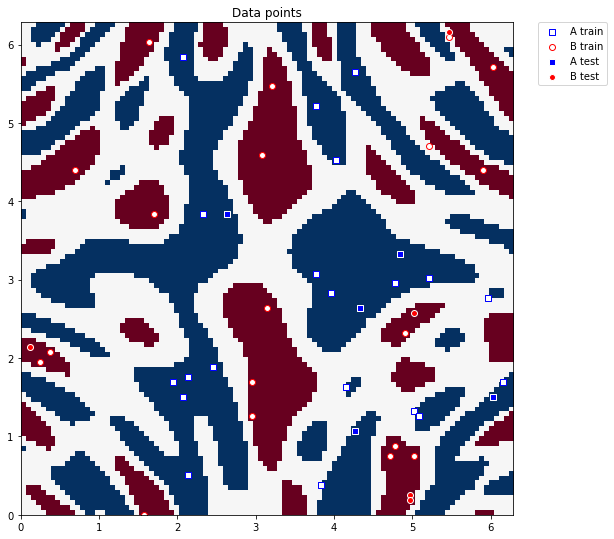

In [14]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (30, 10))
axdata = fig.add_subplot(131)
axdata.set_title("Data points")
axdata.set_ylim(0, 2 * np.pi)
axdata.set_xlim(0, 2 * np.pi)

axdata.imshow(
    np.asmatrix(sample_total).T,
    interpolation = "nearest",
    origin = "lower",
    cmap = "RdBu",
    extent = [0, 2 * np.pi, 0, 2 * np.pi],
)

plt.scatter(
    train_data[np.where(train_labels[:] == 0), 0],
    train_data[np.where(train_labels[:] == 0), 1],
    marker = 's', 
    facecolors = 'w', 
    edgecolors = 'b',
    label = "A train"
)

plt.scatter(
    train_data[np.where(train_labels[:] == 1), 0],
    train_data[np.where(train_labels[:] == 1), 1],
    marker = 'o', 
    facecolors = 'w', 
    edgecolors = 'r',
    label = "B train"
)

plt.scatter(
    test_data[np.where(test_labels[:] == 0), 0],
    test_data[np.where(test_labels[:] == 0), 1],
    marker = 's', 
    facecolors = 'b', 
    edgecolors = "w",
    label = "A test"
)

plt.scatter(
    test_data[np.where(test_labels[:] == 1), 0],
    test_data[np.where(test_labels[:] == 1), 1],
    marker = 'o', 
    facecolors = 'r', 
    edgecolors = "w",
    label = "B test"
)
            
plt.legend(bbox_to_anchor = (1.05, 1), loc = "upper left", borderaxespad = 0.0)

plt.show()

* We will use a quantum variational circuit to help us compute the kernel matrix with entries the inner products of the corresponding quantum states

In [21]:
import qiskit.opflow as opflow

def calculate_kernel(feature_map, datapoint1, datapoint2 = None):
    circuits1 = []
    circuits2 = []

    if datapoint2 is None:
        datapoint2 = datapoint1

    circuits1 = opflow.CircuitStateFn(feature_map).bind_parameters(
        {
            param:vals for (param, vals) in zip(feature_map.parameters, np.transpose(datapoint1).tolist())
        }
    )

    circuits2 = opflow.CircuitStateFn(feature_map).bind_parameters(
        {
            param:vals for (param, vals) in zip(feature_map.parameters, np.transpose(datapoint2).tolist())
        }
    )

    # calculate the kernel
    kernel = np.abs((~circuits1.to_matrix_op() @ circuits2.to_matrix_op()).eval()) ** 2

    return kernel

* Implement the feature map with the ZZFeatureMap variational circuit to map the data into the feature space and calculate the kernel matrix

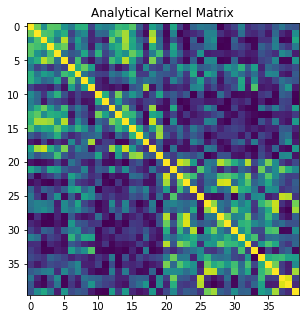

In [22]:
from qiskit.circuit.library import ZZFeatureMap

feature_map = ZZFeatureMap(feature_dimension = 2, reps = 2)

circuits1 = opflow.CircuitStateFn(feature_map).bind_parameters(
    {
        param:vals for (param, vals) in zip(feature_map.parameters, np.transpose(train_data).tolist())
    }
)

kernel = calculate_kernel(feature_map, train_data)

plt.figure(figsize = (5, 5))
plt.imshow(np.asmatrix(kernel), interpolation = 'nearest', origin = 'upper')
plt.title("Analytical Kernel Matrix")
plt.show()

* Kernel matrix properties:

1. Each row / column represent the transition ampliture of a data point with respect to other datapoint
2. Diagonal element are 1, since metric (inner product) of a datapoint with itself is is 1, since we are talking for quentum states
3. Matrix is symmetric, so the ij entries are the same as ji Kij = Kji

In [33]:
# calculate the training and test kernels
train_kernel = calculate_kernel(feature_map, train_data)
test_kernel = calculate_kernel(feature_map, test_data, train_data)

* Use the classical algorithm of support vector machines to create the classifier with the help of sklearn library (https://scikit-learn.org/stable/modules/svm.html)

In [38]:
from sklearn.svm import SVC

model = SVC(kernel = 'precomputed')
model.fit(train_kernel, train_labels)

# get predictions on training examples and compare them with the test labels
predictions = model.predict(test_kernel)
print(predictions)
print(test_labels)

[0 0 0 0 0 1 1 1 1 1]
[0 0 0 0 0 1 1 1 1 1]


* Create a graph with the trained and test data and mark if any point from test is wrongly predicted

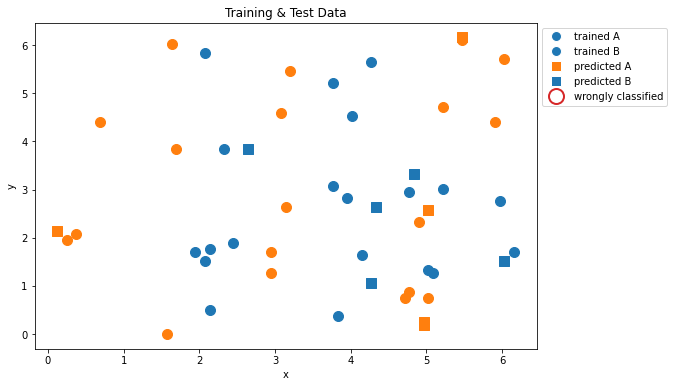

In [42]:
from matplotlib.lines import Line2D

plt.figure(figsize = (9, 6))

for feature, label in zip(train_data, train_labels):
    marker = 'o' 

    color = 'C0' if label == 0 else 'C1'

    plt.scatter(feature[0], feature[1], marker = marker, s = 100, color = color)
    
for feature, label, pred in zip(test_data, test_labels, predictions):
    marker = 's' 
    color = 'C0' if pred == 0 else 'C1'

    plt.scatter(feature[0], feature[1], marker = marker, s = 100, color = color)

    if label != pred:  # mark wrongly classified
        plt.scatter(feature[0], feature[1], marker = 'o', s = 500, linewidths = 2.5, facecolor = 'none', edgecolor = 'C3')

legend_elements = [
    Line2D([0], [0], marker = 'o', c = 'w', mfc = 'C0', label = 'trained A', ms = 10),
    Line2D([0], [0], marker = 'o', c = 'w', mfc = 'C0', label = 'trained B', ms = 10),
    Line2D([0], [0], marker = 's', c = 'w', mfc = 'C1', label = 'predicted A', ms = 10),
    Line2D([0], [0], marker = 's', c = 'w', mfc = 'C0', label = 'predicted B', ms = 10),
    Line2D([0], [0], marker = 'o', c = 'w', mfc = 'none', mec = 'C3', label = 'wrongly classified', mew = 2, ms = 15)
]

plt.legend(handles = legend_elements, bbox_to_anchor = (1, 1), loc = 'upper left')
    
plt.title('Training & Test Data')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [34]:
model.score(test_kernel, test_labels)

1.0